Epoch 1/10
1765/1765 [==============================] - 24s 7ms/step - loss: 0.3798 - accuracy: 0.8290 - val_loss: 0.2596 - val_accuracy: 0.8939
Epoch 2/10
1765/1765 [==============================] - 12s 7ms/step - loss: 0.2101 - accuracy: 0.9169 - val_loss: 0.2453 - val_accuracy: 0.9007
Epoch 3/10
1765/1765 [==============================] - 12s 7ms/step - loss: 0.1240 - accuracy: 0.9548 - val_loss: 0.3443 - val_accuracy: 0.8826
Epoch 4/10
1765/1765 [==============================] - 12s 7ms/step - loss: 0.0593 - accuracy: 0.9799 - val_loss: 0.3716 - val_accuracy: 0.8972
Epoch 5/10
1765/1765 [==============================] - 12s 7ms/step - loss: 0.0322 - accuracy: 0.9891 - val_loss: 0.4591 - val_accuracy: 0.8960
Epoch 6/10
1765/1765 [==============================] - 12s 7ms/step - loss: 0.0201 - accuracy: 0.9928 - val_loss: 0.5214 - val_accuracy: 0.8879
Epoch 7/10
1765/1765 [==============================] - 13s 7ms/step - loss: 0.0145 - accuracy: 0.9952 - val_loss: 0.6052 - val_ac

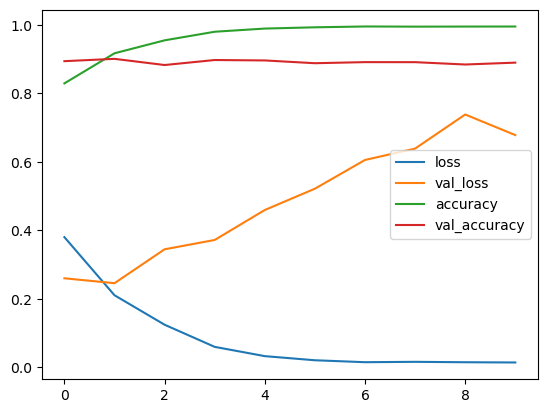

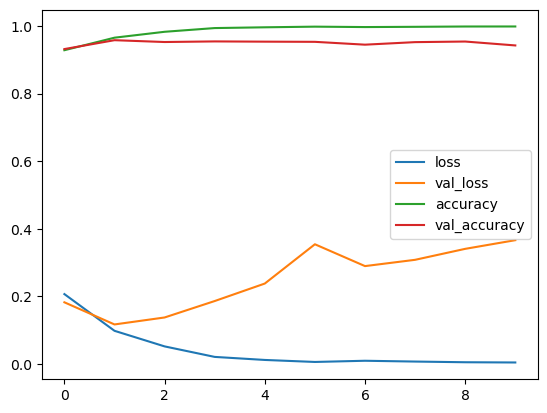

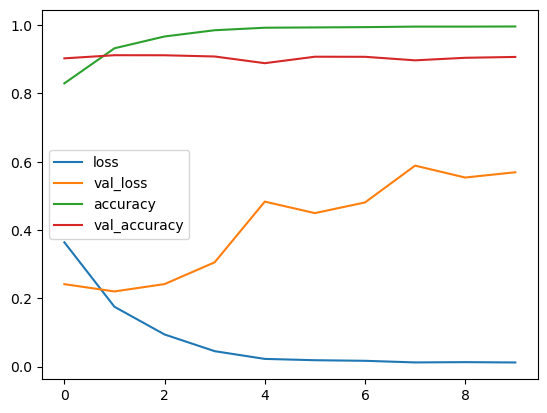

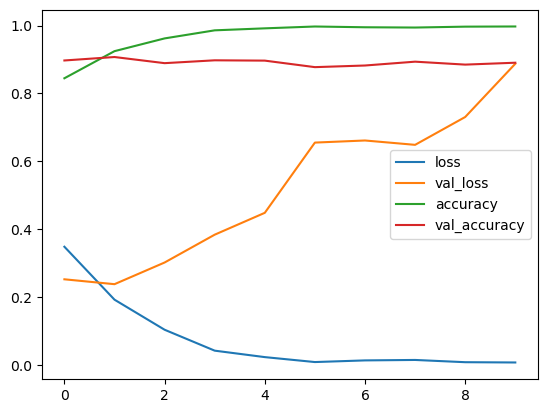

{'Personality': 'ENFP', 'SNA Results': [('I', 1.0), ('enjoy', 1.0), ('coding', 1.0), ('and', 1.0), ('analyzing', 1.0), ('networks!', 1.0)]}


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import networkx as nx
import pickle

# Load the dataset
df = pd.read_csv('MBTI 500.csv')

# Function to balance dataset for a specific personality trait
def balance_trait(df, trait):
    df_trait = df[df['type'].apply(lambda x: trait not in x)]
    df_tbr = df_trait.head(len(df) - len(df_trait))
    balanced_df = df[~df.index.isin(df_tbr.index)]
    return balanced_df

# Balancing datasets for each personality trait
IE_balanced_df = balance_trait(df, 'E')
SN_balanced_df = balance_trait(df, 'S')
TF_balanced_df = balance_trait(df, 'F')
JP_balanced_df = balance_trait(df, 'J')

# Function to prepare data for model
def createType(data, class_type):
    data = data[['posts', 'type']]
    data[str(class_type)] = data['type'].apply(lambda x: 1 * (str(class_type) in x))
    return data.drop('type', axis=1)

IE_df = createType(IE_balanced_df, 'I')
SN_df = createType(SN_balanced_df, 'N')
TF_df = createType(TF_balanced_df, 'F')
JP_df = createType(JP_balanced_df, 'P')

MAX_VOCAB = 20000  # Max number of words to consider in vocabulary

# Preprocessing function
def customPreProcess(dataset, target):
    df_train, df_test, y_train, y_test = train_test_split(
        dataset['posts'], dataset[str(target)], test_size=0.3, random_state=200)
    
    tokenizer = Tokenizer(num_words=MAX_VOCAB)
    tokenizer.fit_on_texts(df_train)
    tok_train = tokenizer.texts_to_sequences(df_train)
    tok_test = tokenizer.texts_to_sequences(df_test)
    V = len(tokenizer.word_index)
    
    pad_train = pad_sequences(tok_train)
    T = pad_train.shape[1]
    pad_test = pad_sequences(tok_test, maxlen=T)
    
    return pad_train, pad_test, y_train, y_test, T, V, tokenizer

# Preprocess for all traits
I_Xtrain, I_Xtest, I_ytrain, I_ytest, I_T, I_V, I_tokenizer = customPreProcess(IE_df, 'I')
N_Xtrain, N_Xtest, N_ytrain, N_ytest, N_T, N_V, N_tokenizer = customPreProcess(SN_df, 'N')
F_Xtrain, F_Xtest, F_ytrain, F_ytest, F_T, F_V, F_tokenizer = customPreProcess(TF_df, 'F')
P_Xtrain, P_Xtest, P_ytrain, P_ytest, P_T, P_V, P_tokenizer = customPreProcess(JP_df, 'P')

# CNN model definition
def CNN(X_train, X_test, y_train, y_test, T, V):
    i = Input(shape=(T,))
    x = Embedding(V + 1, 20)(i)
    x = Conv1D(32, 3, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Conv1D(64, 3, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Conv1D(128, 3, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(i, x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    r = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
    return model, r

# Train models for each trait
IE_CNN, IE_report = CNN(I_Xtrain, I_Xtest, I_ytrain, I_ytest, I_T, I_V)
SN_CNN, SN_report = CNN(N_Xtrain, N_Xtest, N_ytrain, N_ytest, N_T, N_V)
TF_CNN, TF_report = CNN(F_Xtrain, F_Xtest, F_ytrain, F_ytest, F_T, F_V)
JP_CNN, JP_report = CNN(P_Xtrain, P_Xtest, P_ytrain, P_ytest, P_T, P_V)

# Save models
IE_CNN.save('./CNN_Models/IE_CNN.h5')
SN_CNN.save('./CNN_Models/SN_CNN.h5')
TF_CNN.save('./CNN_Models/TF_CNN.h5')
JP_CNN.save('./CNN_Models/JP_CNN.h5')

# Save tokenizers and metadata
Additional = [I_T, I_V, I_tokenizer, N_T, N_V, N_tokenizer, F_T, F_V, F_tokenizer, P_T, P_V, P_tokenizer]
with open('./CNN_Models/Additional.pickle', 'wb') as file:
    pickle.dump(Additional, file)

print("Models and tokenizers saved!")

# Function to visualize training results
def showReport(report):
    plt.plot(report.history['loss'], label='loss')
    plt.plot(report.history['val_loss'], label='val_loss')
    plt.plot(report.history['accuracy'], label='accuracy')
    plt.plot(report.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()

# Show reports for all traits
showReport(IE_report)
showReport(SN_report)
showReport(TF_report)
showReport(JP_report)

# Social Network Analysis integration
def social_network_analysis(posts):
    G = nx.Graph()
    for post in posts:
        words = post.split()
        for i, word1 in enumerate(words):
            for word2 in words[i+1:]:
                G.add_edge(word1, word2)
    
    centrality = nx.degree_centrality(G)
    sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    return sorted_centrality[:10]

# Personality prediction function
def predict_personality(tweet):
    inp = [tweet]
    with open('./CNN_Models/Additional.pickle', 'rb') as file:
        toks = pickle.load(file)
        I_tok, N_tok, F_tok, P_tok = toks[2], toks[5], toks[8], toks[11]
        
    # Preprocess tweet
    I_post = pad_sequences(I_tok.texts_to_sequences(inp), maxlen=toks[0])
    N_post = pad_sequences(N_tok.texts_to_sequences(inp), maxlen=toks[3])
    F_post = pad_sequences(F_tok.texts_to_sequences(inp), maxlen=toks[6])
    P_post = pad_sequences(P_tok.texts_to_sequences(inp), maxlen=toks[9])
    
    # Load models
    IE_Model = load_model('./CNN_Models/IE_CNN.h5')
    SN_Model = load_model('./CNN_Models/SN_CNN.h5')
    TF_Model = load_model('./CNN_Models/TF_CNN.h5')
    JP_Model = load_model('./CNN_Models/JP_CNN.h5')
    
    # Predictions
    pi = IE_Model.predict(I_post, verbose=0)[0][0]
    pn = SN_Model.predict(N_post, verbose=0)[0][0]
    pf = TF_Model.predict(F_post, verbose=0)[0][0]
    pp = JP_Model.predict(P_post, verbose=0)[0][0]
    
    # SNA integration
    sna_results = social_network_analysis([tweet])
    
    # Personality type
    personality = ('I' if pi >= 0.5 else 'E') + ('N' if pn >= 0.5 else 'S') + \
                  ('F' if pf >= 0.5 else 'T') + ('P' if pp >= 0.5 else 'J')
    
    return {'Personality': personality, 'SNA Results': sna_results}

# Test the function
print(predict_personality("I enjoy coding and analyzing networks!"))
